# Behavioural modelling

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
import theano
import theano.tensor as T
import pymc3 as pm
import arviz as az

## Get decision data 

This includes behavior taken from raw behavioral output files

In [2]:
decision_df = pd.read_csv('../data/decision_df.csv')
decision_df['left_or_right'] = decision_df['current_patch'] == 'right'
decision_df = decision_df.rename(columns={'current_patch_competitors': 'comps_current_in_patch', 'points_gained': 'points_collected'})
data = decision_df


### Get some other information

In [3]:
onset_id_df = pd.read_csv('../data/onset_id_trial_index_df_REVISED.csv')
data = pd.merge(data, onset_id_df[['day', 'block', 'trial_index', 'subject', 'id']], on=['day', 'block', 'trial_index', 'subject'])

In [4]:
onset_id_df

,subject,day,block,id,trial_index,threat
0,for01,1,1,1,0,False
1,for01,1,1,5,1,False
2,for01,1,1,9,2,False
3,for01,1,1,13,3,False
4,for01,1,1,17,4,False
...,...,...,...,...,...,...
12091,for23,2,4,301,67,True
12092,for23,2,4,306,68,True
12093,for23,2,4,311,69,True
12094,for23,2,4,316,70,True


In [5]:
data = data[data['subject'] != 'for07'] # This subject is excluded from the imaging analyses due to insufficient data

### Calculate points earned

In [6]:
competition_points = data.groupby(['subject', 'threat', 'comps_current_in_patch']).mean()['points_collected'].reset_index()\

# Fill in missing conditions based on other subjects - only needed for for21
for sub in competition_points['subject'].unique():
    sub_points = competition_points[competition_points['subject'] == sub]
    for threat in [False, True]:
        for comps in range(1, 7):
            if not comps in sub_points[sub_points['threat'] == threat]['comps_current_in_patch'].values:
                new_row = pd.DataFrame({'subject': [sub], 'threat': [threat], 'comps_current_in_patch': [comps], 
                                        'points_collected': [competition_points.loc[(competition_points['threat'] == threat) & (competition_points['comps_current_in_patch'] == comps), 'points_collected'].mean()]})
                competition_points = pd.concat([competition_points, new_row]).reset_index(drop=True)



In [7]:
competition_points_left = competition_points.rename(columns={'points_collected': 'mean_points_left', 'comps_current_in_patch': 'left_conspecifics_number'}) 
competition_points_right = competition_points.rename(columns={'points_collected': 'mean_points_right', 'comps_current_in_patch': 'right_conspecifics_number'})
data = pd.merge(data, competition_points_left, on=['subject', 'left_conspecifics_number', 'threat'])
data = pd.merge(data, competition_points_right, on=['subject', 'right_conspecifics_number', 'threat'])

### Plot number of points earned depending on threat & competitors

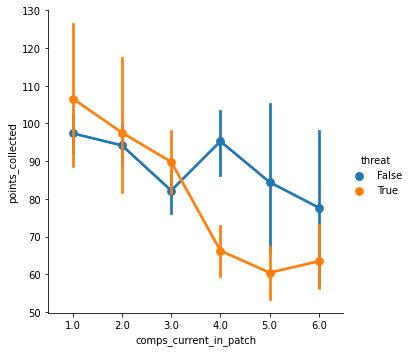

In [8]:
sns.catplot('comps_current_in_patch', 'points_collected', hue='threat', data=competition_points, kind='point')

In [9]:
for n, sub in enumerate(data['subject'].unique()):
    data.loc[data['subject'] == sub, 'subject_idx'] = n

data = data.sort_values(['subject_idx', 'day', 'block', 'trial_index']).reset_index(drop=True)


## Modelling

### Model without learning

In [10]:
n_subs = len(data['subject'].unique())
subject_idx = data['subject_idx'].astype(int)

data['p_caught_left'] = .6 / (data['left_conspecifics_number'] + 1)
data['p_caught_right'] = .6 / (data['right_conspecifics_number'] + 1)
data.loc[data['threat'] == False, ['p_caught_left', 'p_caught_right']] = 0

# Exclude trials where the later option was selected
data['left_or_right_later_excluded'] = data['left_or_right']
data.loc[data['now_or_later'], 'left_or_right_later_excluded'] = np.nan

result_nan_mask = ~data['left_or_right_later_excluded'].isnull().values

with pm.Model() as model:

    group_competitor_threat_weight_mean = pm.Normal('group_competitor_threat_weight_mean', 0, 1)
    group_competitor_threat_weight_sd = pm.HalfNormal('group_competitor_threat_weight_sd', 1)
    competitor_threat_weight_offset = pm.Normal('competitor_threat_weight_offset', 0, 5, shape=n_subs)
    competitor_threat_weight = pm.Deterministic('competitor_threat_weight', group_competitor_threat_weight_mean + group_competitor_threat_weight_sd * competitor_threat_weight_offset)

    temperature = pm.Gamma('temperature', 3, 0.5, shape=n_subs)
    
    v_left = data['mean_points_left'].values * 0.1 + data['p_caught_left'].values * competitor_threat_weight[subject_idx]
    v_right = data['mean_points_right'].values * 0.1 + data['p_caught_right'].values * competitor_threat_weight[subject_idx]
    
    v_left = pm.Deterministic('survival_value_left', v_left)
    v_right = pm.Deterministic('survival_value_right', v_right)
    
    vs = T.stack(v_left, v_right)
    ps = (T.exp(vs / temperature[subject_idx])) / T.sum(T.exp(vs / temperature[subject_idx]), axis=0)
        
    pR = pm.Deterministic('pR', ps[1, :])
           
    decision = pm.Bernoulli('likelihood', p=(pR[result_nan_mask]*.99) + 0.001, observed=data.loc[result_nan_mask, 'left_or_right_later_excluded'].astype(int))
    prior_checks = pm.sample_prior_predictive(samples=50, random_seed=123)

#### Fit model

In [11]:
with model:
    mean_field = pm.fit(method='advi', n=30000)
    
trace = mean_field.sample(1000)

Average Loss = 6,452: 100%|████████████████████████████████████████████████████| 30000/30000 [03:58<00:00, 125.86it/s]
Finished [100%]: Average Loss = 6,452


### Model fit

This uses WAIC on a log scale - higher = better

In [12]:
az.waic(trace)

C:\Users\tobyw\Miniconda3\envs\mne\lib\site-packages\arviz\data\io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
C:\Users\tobyw\Miniconda3\envs\mne\lib\site-packages\arviz\stats\stats.py:1425: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


Computed from 1000 by 11137 log-likelihood matrix

          Estimate       SE
elpd_waic -6181.56    53.94
p_waic       78.70        -

There has been a warning during the calculation. Please check the results.

In [13]:
with model:
    post = pm.sample_posterior_predictive(trace, var_names=['survival_value_left', 'survival_value_right'])

100%|███████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1258.06it/s]


In [14]:
data['survival_value_diff'] = post['survival_value_left'].mean(axis=0) - post['survival_value_right'].mean(axis=0)
data['survival_value_left'] = post['survival_value_left'].mean(axis=0)
data['survival_value_right'] = post['survival_value_right'].mean(axis=0)

### Z-score within subject

In [15]:
for sub in data['subject'].unique():
    data.loc[data['subject'] == sub, 'survival_value_left_Z'] = zscore(data.loc[data['subject'] == sub, 'survival_value_left'])
    data.loc[data['subject'] == sub, 'survival_value_right_Z'] = zscore(data.loc[data['subject'] == sub, 'survival_value_right'])
    data.loc[data['subject'] == sub, 'survival_value_diff_Z'] = zscore(data.loc[data['subject'] == sub, 'survival_value_left'] - data.loc[data['subject'] == sub, 'survival_value_right'])

### Check that choices are different for high/low SV

C:\Users\tobyw\Miniconda3\envs\mne\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


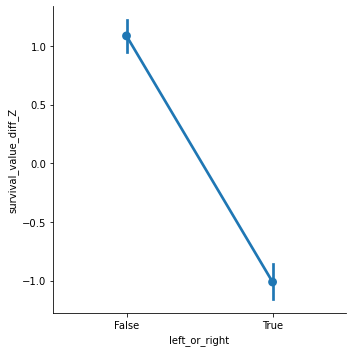

In [16]:
sns.factorplot('left_or_right', 'survival_value_diff_Z', data=data[(data['subject_idx'] == 0) & (data['threat'] == 1)])

(array([9., 0., 3., 4., 2., 0., 0., 1., 0., 1.]),
 array([-167.72540402, -134.60759711, -101.48979019,  -68.37198328,
         -35.25417637,   -2.13636945,   30.98143746,   64.09924438,
          97.21705129,  130.33485821,  163.45266512]),
 <a list of 10 Patch objects>)

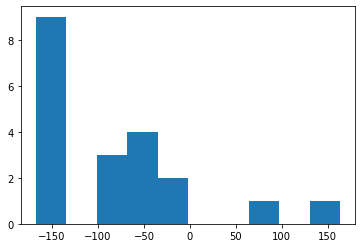

In [17]:
plt.hist(trace['competitor_threat_weight'].mean(axis=0))

C:\Users\tobyw\Miniconda3\envs\mne\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


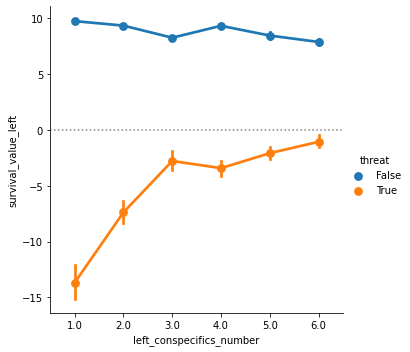

In [18]:
sns.factorplot('left_conspecifics_number', 'survival_value_left', hue='threat', data=data)
plt.axhline(0, linestyle=':', color='gray')

## Model including tendency to stick with current patch

In [19]:
previous_choice = np.stack([1 - data['left_or_right_later_excluded'].shift(1).values, data['left_or_right_later_excluded'].shift(1).values])
previous_choice[np.isnan(previous_choice)] = 0

with pm.Model() as model_stickiness:

    group_competitor_threat_weight_mean = pm.Normal('group_competitor_threat_weight_mean', 0, 1)
    group_competitor_threat_weight_sd = pm.HalfNormal('group_competitor_threat_weight_sd', 1)
    competitor_threat_weight_offset = pm.Normal('competitor_threat_weight_offset', 0, 5, shape=n_subs)
    competitor_threat_weight = pm.Deterministic('competitor_threat_weight', group_competitor_threat_weight_mean + group_competitor_threat_weight_sd * competitor_threat_weight_offset)
    
    stickiness_mean = pm.Normal('stickiness_mean', 1, 1)
    stickiness_sd = pm.HalfNormal('stickiness_sd', 1)
    stickiness_offset = pm.Normal('stickiness_offset', 0, 1, shape=n_subs)
    stickiness = pm.Deterministic('stickiness', group_competitor_threat_weight_mean + group_competitor_threat_weight_sd * competitor_threat_weight_offset)

    temperature = pm.Gamma('temperature', 3, 0.5, shape=n_subs)
    
    v_left = data['mean_points_left'].values * 0.1 + data['p_caught_left'].values * competitor_threat_weight[subject_idx]
    v_right = data['mean_points_right'].values * 0.1 + data['p_caught_right'].values * competitor_threat_weight[subject_idx]
    
    v_left = pm.Deterministic('survival_value_left', v_left)
    v_right = pm.Deterministic('survival_value_right', v_right)
       
    vs = T.stack(v_left, v_right)

    vs = vs + stickiness[subject_idx] * previous_choice
    vs = pm.Deterministic('vs', vs)
    
    ps = (T.exp(vs / temperature[subject_idx])) / T.sum(T.exp(vs / temperature[subject_idx]), axis=0)
        
    pR = pm.Deterministic('pR', ps[1, :])
    pR *= 0.5
           
    decision = pm.Bernoulli('likelihood', p=(pR[result_nan_mask]*.99) + 0.001, observed=data.loc[result_nan_mask, 'left_or_right_later_excluded'].astype(int))
    prior_checks = pm.sample_prior_predictive(samples=50, random_seed=123)

#### Fit model

In [20]:
with model_stickiness:
    mean_field = pm.fit(method='advi', n=30000)
    
trace_stickiness = mean_field.sample(1000)

Average Loss = 9,926.6: 100%|██████████████████████████████████████████████████| 30000/30000 [04:21<00:00, 114.59it/s]
Finished [100%]: Average Loss = 9,926.6


In [21]:
az.waic(trace_stickiness)

C:\Users\tobyw\Miniconda3\envs\mne\lib\site-packages\arviz\data\io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


Computed from 1000 by 11137 log-likelihood matrix

          Estimate       SE
elpd_waic -9829.30    60.54
p_waic       20.69        -

(array([3., 2., 3., 1., 2., 3., 1., 2., 1., 2.]),
 array([0.07736384, 0.36270791, 0.64805199, 0.93339606, 1.21874013,
        1.50408421, 1.78942828, 2.07477236, 2.36011643, 2.64546051,
        2.93080458]),
 <a list of 10 Patch objects>)

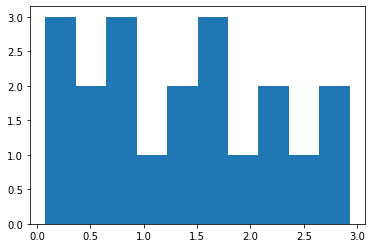

In [22]:
plt.hist(trace_stickiness['stickiness'].mean(axis=0))

## Model with learning

Bayesian mean tracker (BMT) model for learning reward value

### Learning model updates

In [23]:
def bmt_update(outcome, n_competitors, trial_type, V, var, kGain, theta):
        
    sub_idx = T.arange(n_competitors.shape[0])
    trial_type_selector = T.gt(trial_type, 0).astype('int16')

    kGain = T.set_subtensor(kGain[n_competitors, trial_type_selector, sub_idx], var[n_competitors, trial_type_selector, sub_idx] / (var[n_competitors, trial_type_selector, sub_idx] + T.power(theta, 2)))  
    
    pe = outcome - V[n_competitors, trial_type_selector, sub_idx]
    
    Vnew = T.set_subtensor(V[n_competitors, trial_type_selector, sub_idx], V[n_competitors, trial_type_selector, sub_idx] + kGain[n_competitors, trial_type_selector, sub_idx] * pe)
    var = T.set_subtensor(var[n_competitors, trial_type_selector, sub_idx], var[n_competitors, trial_type_selector, sub_idx] * (1 - kGain[n_competitors, trial_type_selector, sub_idx]))
    
    return Vnew, var, kGain, pe, V


In [24]:
data['all_trial_index'] = np.nan
for sub in data['subject_idx'].unique():
    data.loc[data['subject_idx'] == sub, 'all_trial_index'] = np.arange(len(data[data['subject_idx'] == sub]))

# Score on each trial
trial_outcomes = data[['all_trial_index', 'points_collected', 'subject_idx']].pivot(index='all_trial_index', columns='subject_idx', values='points_collected').reset_index().iloc[:, 1:].values
nan_mask = T.as_tensor_variable(trial_outcomes.T.flatten())
trial_outcomes = np.vstack([np.zeros((1, n_subs)), trial_outcomes[:-1, :]])  # Add 0th trial
trial_outcomes[np.isnan(trial_outcomes)] = 0
# trial_outcomes *= 0.01

# Number of competitors on each trial
trial_competitors = data[['all_trial_index', 'comps_current_in_patch', 'subject_idx']].pivot(index='all_trial_index', columns='subject_idx', values='comps_current_in_patch').reset_index().iloc[:, 1:].values.astype(int) - 1
trial_competitors = np.vstack([np.zeros((1, n_subs)), trial_competitors[:-1, :]])

# Deal with nan - these won't used because the outcome variable will be NaN
trial_competitors[trial_competitors < 0] = 0
trial_competitors[trial_competitors > 5] = 0
trial_competitors = trial_competitors.astype(int)

# Threat level each trial
trial_threat = data[['all_trial_index', 'threat', 'subject_idx']].pivot(index='all_trial_index', columns='subject_idx', values='threat').reset_index().iloc[:, 1:].values.astype(float)
trial_threat = np.vstack([np.zeros((1, n_subs)), trial_threat[:-1, :]])

# Whether or not caught on each trial
trial_caught = data[['all_trial_index', 'shocks_gained', 'subject_idx']].pivot(index='all_trial_index', columns='subject_idx', values='shocks_gained').reset_index().iloc[:, 1:].values.astype(np.float64)
trial_caught = np.vstack([np.zeros((1, n_subs)), trial_caught[:-1, :]])
trial_caught[np.isnan(trial_caught)] = 0 # Remove NaN

In [25]:
n_subs = len(data['subject'].unique())
subject_idx = data['subject_idx'].astype(int)

data['p_caught_left'] = .6 / (data['left_conspecifics_number'] + 1)
data['p_caught_right'] = .6 / (data['right_conspecifics_number'] + 1)
data.loc[data['threat'] == False, ['p_caught_left', 'p_caught_right']] = 0

# Exclude trials where the later option was selected
data['left_or_right_later_excluded'] = data['left_or_right']
data.loc[data['now_or_later'], 'left_or_right_later_excluded'] = np.nan

# Useful values
left_conspecifics = T.as_tensor_variable((data['left_conspecifics_number'].astype(int) - 1).values)
right_conspecifics = T.as_tensor_variable((data['right_conspecifics_number'].astype(int) - 1).values)

trial_outcomes = T.as_tensor_variable(trial_outcomes)
trial_competitors = T.as_tensor_variable(trial_competitors)
trial_caught = T.as_tensor_variable(trial_caught)
trial_threat = T.as_tensor_variable(trial_threat)

nan_mask = T.as_tensor_variable(nan_mask)
result_nan_mask = ~data['left_or_right_later_excluded'].isnull().values

from scipy.spatial.distance import cdist
cov = (1 - cdist(np.arange(6)[:, None], np.arange(6)[:, None]) / 5)

with pm.Model() as bmt_model:
    
    # PARAMETERS #
    
    # Threat weight
    group_competitor_threat_weight_mean = pm.Normal('group_competitor_threat_weight_mean', 0, 1)
    group_competitor_threat_weight_sd = pm.HalfNormal('group_competitor_threat_weight_sd', 5)
    competitor_threat_weight_offset = pm.Normal('competitor_threat_weight_offset', 0, 1, shape=n_subs)
    competitor_threat_weight = pm.Deterministic('competitor_threat_weight', group_competitor_threat_weight_mean + group_competitor_threat_weight_sd * competitor_threat_weight_offset)

    # Softmax temperature
    temperature = pm.Gamma('temperature', 3, 1, shape=n_subs)

    # BMT theta - fitting doesn't work if this is free, so we fix it to 1
    theta = 1
        
    # Learning about reward
    V_estimate = T.ones((6, 2, n_subs)) * (trial_outcomes.mean() * 0.1)  # Starting estimate equal to the mean of rewards
    var_estimate = T.ones((6, 2, n_subs))
    kGain_estimate = T.ones((6, 2, n_subs))
    
    #########################
    # LEARNING ABOUT REWARD #
    #########################
    bmt_result, _ = theano.scan(fn=bmt_update,
                                  sequences=[trial_outcomes * 0.1, trial_competitors, trial_threat],
                                  outputs_info=[V_estimate, var_estimate, kGain_estimate, None, None],
                                  non_sequences=[theta])

    _, reward_var, _, _, V = bmt_result
    
    V = pm.Deterministic('V', V)

    # Reshape outputs
    V_reshaped = V.transpose(3, 0, 1, 2).reshape((V.shape[0] * V.shape[3], V.shape[1], V.shape[2]))
    V_reshaped = V_reshaped[~T.isnan(nan_mask), ...]
    V_reshaped = pm.Deterministic('V_reshaped', V_reshaped)
        
    trial_idx = T.arange(len(data))
    trial_threat_selector = T.gt(trial_threat, 0).astype('int16').T.flatten()
    trial_threat_selector = trial_threat_selector[~T.isnan(nan_mask)]
    
    v_left = V_reshaped[trial_idx, left_conspecifics, trial_threat_selector] + data['p_caught_left'].values * competitor_threat_weight[subject_idx]
    v_right = V_reshaped[trial_idx, right_conspecifics, trial_threat_selector] + data['p_caught_right'].values * competitor_threat_weight[subject_idx]
    
    v_left = pm.Deterministic('survival_value_left', v_left)
    v_right = pm.Deterministic('survival_value_right', v_right)
    
    vs = T.stack(v_left, v_right) 
    vs = pm.Deterministic('vs', vs)

    ps = (T.exp(vs / temperature[subject_idx])) / T.sum(T.exp(vs / temperature[subject_idx]), axis=0)
    pR = pm.Deterministic('pR', ps[1, :])
    decision = pm.Bernoulli('likelihood', p=(pR[result_nan_mask]*.99) + 0.001, observed=data.loc[result_nan_mask, 'left_or_right_later_excluded'].astype(int))
    prior_checks = pm.sample_prior_predictive(samples=100, random_seed=123)

### An example of how learned value evolves over the course of the task for one subject

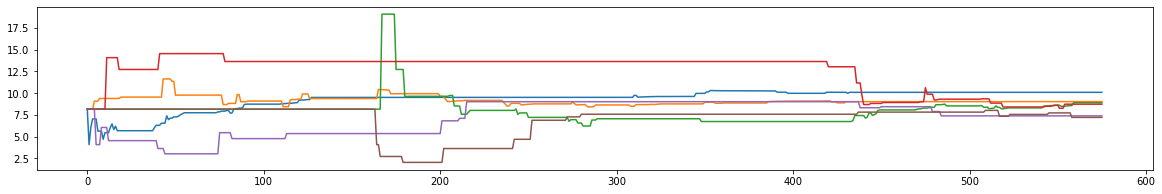

In [26]:
plt.figure(figsize=(20, 3))
for i in range(6):
    plt.plot(prior_checks['V'][:, i, 0, 0]);

### Fit model

In [27]:
with bmt_model:
    bmt_mean_field = pm.fit(method='advi', n=30000)
    
bmt_trace = bmt_mean_field.sample(2000)

Average Loss = 6,421: 100%|███████████████████████████████████████████████████| 30000/30000 [9:27:33<00:00,  1.14s/it]
Finished [100%]: Average Loss = 6,420.9


In [28]:
az.waic(bmt_trace)

C:\Users\tobyw\Miniconda3\envs\mne\lib\site-packages\arviz\data\io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
C:\Users\tobyw\Miniconda3\envs\mne\lib\site-packages\arviz\stats\stats.py:1425: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


Computed from 2000 by 11137 log-likelihood matrix

          Estimate       SE
elpd_waic -6216.19    52.21
p_waic       51.51        -

There has been a warning during the calculation. Please check the results.

In [30]:
comp = az.compare({'Learning': bmt_trace, 'No learning': trace, 'Choice stickiness': trace_stickiness}, ic='WAIC')

C:\Users\tobyw\Miniconda3\envs\mne\lib\site-packages\arviz\stats\stats.py:1425: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
C:\Users\tobyw\Miniconda3\envs\mne\lib\site-packages\arviz\data\io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
C:\Users\tobyw\Miniconda3\envs\mne\lib\site-packages\arviz\stats\stats.py:1425: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
C:\Users\tobyw\Miniconda3\envs\mne\lib\site-packages\arv

In [31]:
comp

,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
No learning,0,-6181.56,78.701,0,NaN,53.4938,0,True,log
Learning,1,-6216.19,51.512,34.6283,NaN,54.4868,32.5677,True,log
Choice stickiness,2,-9829.3,20.6946,3647.74,0,58.9689,76.7909,False,log


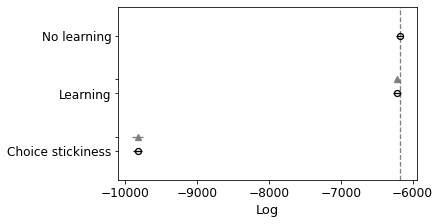

In [32]:
az.plot_compare(comp, insample_dev=False);

In [33]:
data['survival_value_diff_learning'] = bmt_trace['survival_value_left'].mean(axis=0) - bmt_trace['survival_value_right'].mean(axis=0)
data['survival_value_left_learning'] = bmt_trace['survival_value_left'].mean(axis=0)
data['survival_value_right_learning'] = bmt_trace['survival_value_right'].mean(axis=0)

In [34]:
for sub in data['subject'].unique():
    data.loc[data['subject'] == sub, 'survival_value_left_learning_Z'] = zscore(data.loc[data['subject'] == sub, 'survival_value_left_learning'])
    data.loc[data['subject'] == sub, 'survival_value_right_learning_Z'] = zscore(data.loc[data['subject'] == sub, 'survival_value_right_learning'])
    data.loc[data['subject'] == sub, 'survival_value_diff_learning_Z'] = zscore(data.loc[data['subject'] == sub, 'survival_value_left_learning'] - data.loc[data['subject'] == sub, 'survival_value_right_learning'])

### Check that choices are different for high/low SV

C:\Users\tobyw\Miniconda3\envs\mne\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


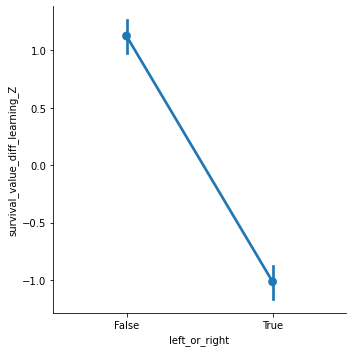

In [35]:
sns.factorplot('left_or_right', 'survival_value_diff_learning_Z', data=data[(data['subject_idx'] == 0) & (data['threat'] == 1)])

(array([1., 2., 5., 5., 5., 0., 1., 0., 0., 1.]),
 array([-304.88960937, -244.22924459, -183.56887981, -122.90851503,
         -62.24815025,   -1.58778547,   59.0725793 ,  119.73294408,
         180.39330886,  241.05367364,  301.71403842]),
 <a list of 10 Patch objects>)

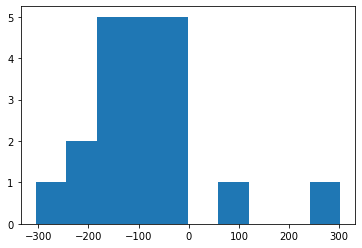

In [36]:
plt.hist(bmt_trace['competitor_threat_weight'].mean(axis=0))

C:\Users\tobyw\Miniconda3\envs\mne\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


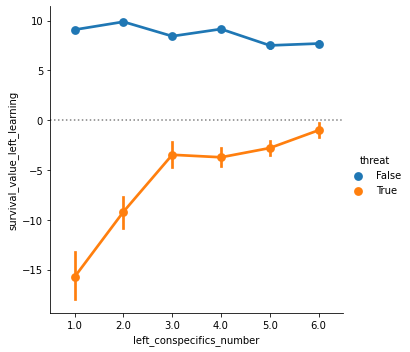

In [37]:
sns.factorplot('left_conspecifics_number', 'survival_value_left_learning', hue='threat', data=data)
plt.axhline(0, linestyle=':', color='gray')

### Save data

In [38]:
data.to_csv('../data/decision_data_REVISED.csv', index=False)

In [39]:
np.save('../data/threat_param_values_REVISED', trace['competitor_threat_weight'].mean(axis=0))